In [1]:
import sys
import os
sys.path.append("../analysis")

In [2]:
import re
from itertools import product

In [3]:
import uproot
import awkward as ak
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import vector
import hist
from hist import Hist

In [4]:
import analysis.datasets.local as datasets
import analysis.selection.cuts as cuts

In [5]:
from analysis.selection.extend import extend_dimuon_q2, extend_dtf
from analysis.selection.mctruth import mumupipipiz_rare_truth_info, mumupipipiz_resonant_truth_info, extend_mctruth

In [6]:
from analysis.plotting.plotting import set_lhcb_style
set_lhcb_style()

In [7]:
import ROOT

Welcome to JupyROOT 6.30/02


Find the root files

In [8]:
decay = 'B2omegaMuMu'
eventtypes = [11114401, 11144405, 13144401, 11442001]
magpol = ['magdown', 'magup']
datatypes = [2016, 2017, 2018]

In [9]:
def find_files(eventype, magpol, datatype):
    datadir = datasets.get_local_data_path(decay, eventype)
    fs = [os.path.join(datadir, f'{pol}_{year}.root') for year, pol in product(datatypes, magpol)]
    return fs

In [10]:
files = { evttype: find_files(evttype, magpol, datatypes) for evttype in eventtypes}

Prepare the df

In [11]:
jpsicut = '&&'.join([c.format('Jpsi') for c in cuts.jpsiwindow])
def filter(df):
    df = df.Filter(jpsicut, 'Jpsi window')
    return df

In [12]:
def prepare_df(files, mctruthinfo=None, jpsiwindow=False):
    df = ROOT.RDataFrame('DecayTree', files)
    if jpsiwindow:
        df = filter(df)
    df = extend_dimuon_q2(df)
    df = extend_dtf(df)
    if mctruthinfo:
        df = extend_mctruth(df, mctruthinfo)
    return df

In [13]:
omegamumu_mctruth = mumupipipiz_rare_truth_info(("B", 511), ("omega", 223))
omegajpsi_mctruth = mumupipipiz_resonant_truth_info(("B", 511), ("Jpsi", 443), ("omega", 223))
etajpsi_mctruth = mumupipipiz_resonant_truth_info(("B", 531), ("Jpsi", 443), ("omega", 221))
mctruthinfo = {
    11114401: omegamumu_mctruth,
    11144405: omegajpsi_mctruth,
    13144401: etajpsi_mctruth
}

In [14]:
dfbs = prepare_df(files[13144401], mctruthinfo[13144401], jpsiwindow=True)

In [15]:
allcols = dfbs.GetColumnNames()
allcols =  [str(c) for c in allcols]
pattern = re.compile(r'^(truth)|(.*BKGCAT.*)')
cols = [c for c in allcols if pattern.match(c)]
cols += ["B_M", "B_Jpsi_DTF_M", "B_piz_DTF_M", "Jpsi_M", "omega_M"]

In [16]:
etacut = '&'.join([c.format('omega') for c in cuts.etawindow])
omegacut = '&'.join([c.format('omega') for c in cuts.omegawindow])

In [17]:
arr_bs = ak.to_dataframe(ak.from_rdataframe(dfbs, cols))

In [18]:
arr_bs = arr_bs.query(etacut)

In [19]:
from analysis.utils.histograms import *
from analysis.variables import mass_observables

In [20]:
h2g = hist_from_var( mass_observables[8], arr_bs[arr_bs.truth_b2g])
h1g = hist_from_var( mass_observables[8], arr_bs[arr_bs.truth_b1g])
h0g = hist_from_var( mass_observables[8], arr_bs[arr_bs.truth_b0g])

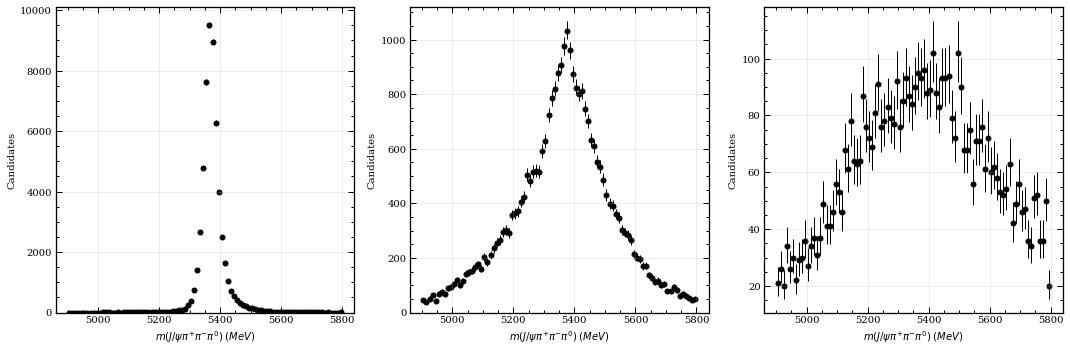

In [21]:
fig, ax =  plt.subplots(1, 3, figsize=(15, 5))
plot_hist(ax[0], h2g, histtype='errorbar')
plot_hist(ax[1], h1g, histtype='errorbar')
plot_hist(ax[2], h0g, histtype='errorbar')
plt.tight_layout()
#save_fig('KstarPlus_M')

In [22]:
bs2g = arr_bs.truth_b2g
bs1g = arr_bs.truth_b1g
bs0g = arr_bs.truth_b0g

In [23]:
from analysis.plotting.rootplots import setLHCbStyle
setLHCbStyle()

-------------------------
Set LHCb Style - Feb 2012
-------------------------


In [24]:
mass = ROOT.RooRealVar("mass", "M(J/#psi#eta) (MeV)", 5000, 5800)
#ws = ROOT.RooWorkspace(f"ws_mc")
#ws.Import(mass)

In [25]:
ds_bs2g = ROOT.RooDataSet.from_numpy({"mass": arr_bs[bs2g].B_Jpsi_DTF_M.to_numpy()}, [mass])
ds_bs1g = ROOT.RooDataSet.from_numpy({"mass": arr_bs[bs1g].B_Jpsi_DTF_M.to_numpy()}, [mass])
ds_bs0g = ROOT.RooDataSet.from_numpy({"mass": arr_bs[bs0g].B_Jpsi_DTF_M.to_numpy()}, [mass])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 2 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 1506 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 1307 out-of-range events


In [26]:
pdf_bs0g = ROOT.RooKeysPdf(f"kdBz0g", f"kdBz0g", mass, ds_bs0g, ROOT.RooKeysPdf.MirrorBoth, 1)

In [27]:
pdf_bs1g = ROOT.RooKeysPdf(f"kdBz1g", f"kdBz1g", mass, ds_bs1g, ROOT.RooKeysPdf.MirrorBoth, 1)

In [28]:
def create_ws(name, mass, pdfb0g, pdfb1g, sigmodel="cb2"):
    ws = ROOT.RooWorkspace(name)
    ws.Import(mass)
    ws.Import(pdfb0g)
    ws.Import(pdfb1g)

    if sigmodel == "cb":
        ws.factory("CBShape::sigmod(mass,mean[5200,5400],s1[0.1,200.],a1[-10.,0.],n1[5.])")
    elif sigmodel == "cbg":
        ws.factory("CBShape::cb1(mass,mean[5200,5400],s1[0.1,200.],a1[-10.,0.],n1[5.])")
        ws.factory("Gaussian::g(mass,mean,s[0.1,200])")
        ws.factory("SUM::sigmod(f1[0.5,0.,1.]*cb1,g)")
    elif sigmodel == "cb2":
        ws.factory("CBShape::cb1(mass,mean[5200,5400],s1[0.1,200.],a1[-10.,0.],n1[5.0])")
        ws.factory("CBShape::cb2(mass,mean,s1,a2[0.,10.],n2[5])")
        ws.factory("SUM::sigmod(f1[0.5,0.,1.]*cb1,cb2)")
    elif sigmodel == "cb2g":
        ws.factory("CBShape::cb1(mass,mean[5200,5400],s1[0.1,200.],a1[-10.,0.],n1[5.])")
        ws.factory("CBShape::cb2(mass,mean,s2[0.1,200],a2[0.,10.],n2[5.])")
        ws.factory("Gaussian::g(mass,mean,s[0.1,200])")
        ws.factory("SUM::sigmod(f1[0.5,0.,1.]*cb1,cb2)")
    else:
        raise ValueError(f"Unknown signal model {sigmodel}")

    kdBz0g = pdfb0g.GetName()    
    kdBz1g = pdfb1g.GetName()    

    ws.factory(f"SUM::model(F0[0.5,0.,1.]*{kdBz0g},F1[0.5,0.,1.]*{kdBz1g},sigmod)")
    #ws.factory("ExtendPdf::Bz(sigmod,S[1000,0,100000])")
    #ws.factory(f"ExtendPdf::Bz0g({kdBz0g},S0g[1000,0,100000])")
    #ws.factory(f"ExtendPdf::Bz1g({kdBz1g},S1g[1000,0,100000])")
    #ws.factory("ExtendPdf::Bkg(Exponential::exp(mass,tau[-0.01,0.01]),B[1000,0,1000000])")
    #ws.factory("SUM::model(S*Bz,S0g*Bz0g,S1g*Bz1g)")
    #ws.factory("SUM::model(Bg*BkgGamma,B*Bkg)")

    return ws

def fit_mass(ws, pdf, arr):
    mass = ws["mass"]
    model = ws[pdf]
    
    data = ROOT.RooDataSet.from_numpy({"mass": arr}, [mass])
    data.SetName("ds")
    #ws.Import(data)

    r = model.fitTo(data, Save=True, PrintLevel=-1)
    r.Print("v")
    
    return r

def plot_fit(ws, model, data, name, components=None, params=False, t="cb2"):

    mass = ws['mass']
    model = ws['model']

    mframe = mass.frame(Name=f"{name}_frame")
    data.plotOn(mframe)
    model.plotOn(mframe)
    
    if params:
        model.paramOn(mframe, Layout=0.62)
    
    #model.plotOn(mframe, Components={bkg_g}, LineColor="m", LineStyle="--")
    #model.plotOn(mframe, Components={sig}, LineColor="c", LineStyle="-.")

    #if t == "cbg":
    #    sig1 = ws.pdf('cb1')
    #    sig2 = ws.pdf('g')
    #    model.plotOn(mframe, Components={sig1}, LineColor="b", LineStyle="-.")
    #    model.plotOn(mframe, Components={sig2}, LineColor="g", LineStyle="-.")
    
    #if t == "cb2":
    #    sig1 = ws.pdf('cb1')
    #    sig2 = ws.pdf('cb2')
        #model.plotOn(mframe, Components={sig1}, LineColor="b", LineStyle="-.")
        #model.plotOn(mframe, Components={sig2}, LineColor="g", LineStyle="-.")
    
    mframe.GetXaxis().SetTitle( "M(J/#psi #pi^{+}#pi^{-}#pi^{0}) (MeV)")
    mframe.GetXaxis().CenterTitle()
    mframe.GetYaxis().CenterTitle()
    
    c = ROOT.TCanvas(f"c_{name}", f"Canvas {name}", 800, 600)
    mframe.Draw()
    c.SaveAs(f"../output/plots/{name}.png")
    return c


In [127]:
def create_workspace(name, mass, pdfb0g, pdfb1g, peak="Bs"):
    ws = ROOT.RooWorkspace(name+peak)

    mean = ROOT.RooRealVar("mean", "#mu", 5200, 5400)
    sigma = ROOT.RooRealVar("sigma", "#sigma", 0.1, 200)
    a1 = ROOT.RooRealVar("a1", "a1", -10, 0)
    a2 = ROOT.RooRealVar("a2", "a2", 0, 10)    
    n1 = ROOT.RooRealVar("n1", "n1", 5)
    n2 = ROOT.RooRealVar("n2", "n2", 5)

    cb1 = ROOT.RooCBShape("cb1", "cb1", mass, mean, sigma, a1, n1)
    cb2 = ROOT.RooCBShape("cb2", "cb2", mass, mean, sigma, a2, n2)
    f1 = ROOT.RooRealVar("f1", "f1", 0.5, 0., 1.)
    sigmod = ROOT.RooAddPdf("sigmod", "sigmod", [cb1, cb2], [f1])

    F0 =ROOT.RooRealVar("F0", "frac. 0 true #gamma's", 0.5, 0., 1.)
    F1 =ROOT.RooRealVar("F1", "frac. 1 true #gamma 's", 0.5, 0., 1.)
    peakmod = ROOT.RooAddPdf("peakmod", "peakmod", [pdfb0g, pdfb1g, sigmod], [F0, F1])
    ws.Import(peakmod)

#    if peak == "Bs":
#        dm = ROOT.RooRealVar("dm", "dm", -87.4)
#    elif peak == "Bd":
#        dm = ROOT.RooRealVar("dm", "dm", 87.4)
#    else:
#        raise ValueError(f"Unknown peak {peak}")
#    
#    ws.Import(dm) 
#    ws.factory("sum::secmean(mean, dm)")
#    ws.factory("CBShape::minorcb1(mass,secmean,sigma,a1,n1)")
#    ws.factory("CBShape::minorcb2(mass,secmean,sigma,a2,n2)")
#    ws.factory("SUM::minorsigmod(f1*minorcb1,minorcb2)")
#
#    minorsigmod = ws.pdf("minorsigmod")
#    minorb0g = pdfb0g.Clone("minor"+pdfb0g.GetName())
#    minorb1g = pdfb0g.Clone("minor"+pdfb1g.GetName())
#    minorpeakmod = ROOT.RooAddPdf("minorpeakmod", "minorpeakmod", [minorb0g, minorb1g, minorsigmod], [F0, F1])
#    ws.Import(minorpeakmod)
#
#    ws.factory("prod::N0g(F0, N[1000,0,100000])")
#    ws.factory("prod::N1g(F1, N)")
#    ws.factory("sum::N2g(1*N,-1*N0g,-1*N1g)")
#
    ws.Print()
    return ws 


In [129]:
#ws = create_ws("ws", mass, pdf_bs0g, pdf_bs1g, sigmodel="cb2")
#ws.Print()
ws = create_workspace("ws", mass, pdf_bs0g, pdf_bs1g, peak="Bs")

[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooAddPdf::peakmod
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooKeysPdf::kdBz0g
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::F0
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooKeysPdf::kdBz1g
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::F1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooAddPdf::sigmod
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooCBShape::cb1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::sigma
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::a1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBs) importing RooRealVar::n1
[#1] INFO:ObjectH

In [130]:
def plot_fit(mass, data, model, components=None, params=False):
    frame = mass.frame()
    data.plotOn(frame)
    model.plotOn(frame, LineColor=ROOT.kMagenta)
    frame.GetXaxis().SetTitle( "M(J/#psi #pi^{+}#pi^{-}#pi^{0}) (MeV)")
    frame.GetXaxis().CenterTitle()
    frame.GetYaxis().CenterTitle()
    if params:
        model.paramOn(frame, Layout=0.62)
    if components:
        for comp, color, line in components:
            model.plotOn(frame, Components={comp}, LineColor=color, LineStyle=line)
    return frame

Info in <TCanvas::Print>: png file ../output/plots/Bs2etaJpsi_0trueg.png has been created


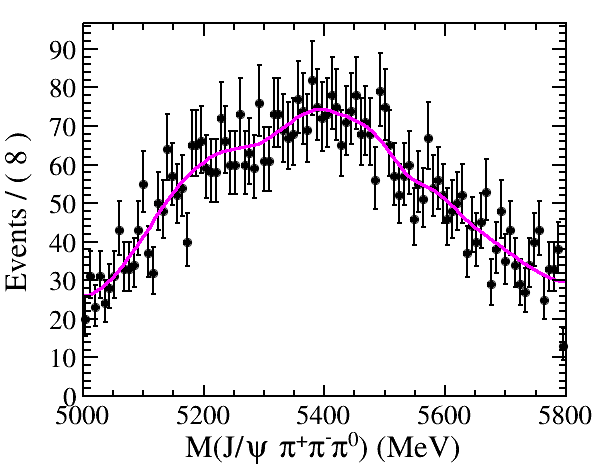

In [131]:
c = ROOT.TCanvas(f"Bs2etaJpsi_0trueg", "", 600, 500)
#frame = plot_fit(mass, ds_bs0g, pdf_bs0g)   
frame = plot_fit(mass, ds_bs0g, ws['kdBz0g'])   
frame.Draw()
c.Draw()
c.SaveAs("../output/plots/Bs2etaJpsi_0trueg.png")

In [132]:
c = ROOT.TCanvas(f"Bs2etaJpsi_1trueg", "", 600, 500)
frame = plot_fit(mass, ds_bs1g, ws['kdBz1g'])   
frame.Draw()
c.SaveAs("../output/plots/Bs2etaJpsi_1trueg.png")

Info in <TCanvas::Print>: png file ../output/plots/Bs2etaJpsi_1trueg.png has been created


In [133]:
pdf = ws["sigmod"]
r = pdf.fitTo(ds_bs2g, Save=True, PrintLevel=-1)
r.Print("v")

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb1,cb2)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization

  RooFitResult: minimized FCN value: 271383, estimated distance to minimum: 0.000288324
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
                    n1    5.0000e+00
                    n2    5.0000e+00

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                    a1   -5.0000e+00   -8.5094e-01 +/-  1.53e-02  <none>
                    a2    5.0000e+00    1.0616e+00 +/-  2.82e-02  <none>
                    f1    5.0000e-01    6.7005e-

In [134]:
c = ROOT.TCanvas(f"Bs2etaJpsi_2trueg", "", 600, 500)
frame = plot_fit(mass, ds_bs2g, pdf, params=True)   
frame.Draw()
c.SaveAs("../output/plots/Bs2etaJpsi_2trueg.png")

Info in <TCanvas::Print>: png file ../output/plots/Bs2etaJpsi_2trueg.png has been created


In [135]:
ds_bs = ROOT.RooDataSet.from_numpy({"mass": arr_bs[bs2g|bs1g|bs0g].B_Jpsi_DTF_M.to_numpy()}, [mass])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 2815 out-of-range events


In [136]:

ws['a1'].setConstant(False)
ws['a2'].setConstant(False)
ws['f1'].setConstant(False)
ws['sigma'].setConstant(False)
ws['mean'].setConstant(False)
model = ws["peakmod"]
r = model.fitTo(ds_bs, Save=True, PrintLevel=-1)
r.Print("v")

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (kdBz0g,kdBz1g)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb1,cb2)
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.05199
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.05199
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.05199
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.05199
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.05199
[#0] WARNING:Eval -- RooAddPdf::updateCoefCac

In [137]:
c = ROOT.TCanvas(f"Bs2etaJpsi_rdmgamma", "", 600, 500)
components = [(ws["sigmod"], "b", "--"), ("kdBz1g", "c", "-."), ("kdBz0g", "g", "-.")]
frame = plot_fit(mass, ds_bs, model, components=components, params=True)   
frame.Draw()
c.SaveAs("../output/plots/Bs2etaJpsi_rdmgamma.png")

[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (sigmod)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: (cb1,cb2)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (kdBz1g)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (kdBz0g)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file ../output/plots/Bs2etaJpsi_rdmgamma.png has been created



Now for $B^{0}\to\omega J/\psi$

In [90]:
dfbd = prepare_df(files[11144405], mctruthinfo[11144405], jpsiwindow=True)
arr_bd = ak.to_dataframe(ak.from_rdataframe(dfbd, cols))

In [91]:
arr_bd = arr_bd.query(omegacut)
bd2g = arr_bd.truth_b2g
bd1g = arr_bd.truth_b1g
bd0g = arr_bd.truth_b0g

In [92]:
ds_bd2g = ROOT.RooDataSet.from_numpy({"mass": arr_bd[bd2g].B_Jpsi_DTF_M.to_numpy()}, [mass])
ds_bd1g = ROOT.RooDataSet.from_numpy({"mass": arr_bd[bd1g].B_Jpsi_DTF_M.to_numpy()}, [mass])
ds_bd0g = ROOT.RooDataSet.from_numpy({"mass": arr_bd[bd0g].B_Jpsi_DTF_M.to_numpy()}, [mass])
ds_bd = ROOT.RooDataSet.from_numpy({"mass": arr_bd[bd2g|bd1g|bd0g].B_Jpsi_DTF_M.to_numpy()}, [mass])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 3 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 2037 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 4285 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 6325 out-of-range events


In [93]:
pdf_bd0g = ROOT.RooKeysPdf(f"kdBz0g", f"kdBz0g", mass, ds_bd0g, ROOT.RooKeysPdf.MirrorBoth, 1)

In [94]:
pdf_bd1g = ROOT.RooKeysPdf(f"kdBz1g", f"kdBz1g", mass, ds_bd1g, ROOT.RooKeysPdf.MirrorBoth, 1)



In [113]:

wsBd = create_workspace("ws", mass, pdf_bd0g, pdf_bd1g, peak="Bd")

[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooAddPdf::peakmod
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooKeysPdf::kdBz0g
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::F0
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooKeysPdf::kdBz1g
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::F1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooAddPdf::sigmod
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooCBShape::cb1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::sigma
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::a1
[#1] INFO:ObjectHandling -- RooWorkspace::import(wsBd) importing RooRealVar::n1
[#1] INFO:ObjectH

Info in <TCanvas::Print>: png file ../output/plots/Bd2omegaJpsi_0trueg.png has been created


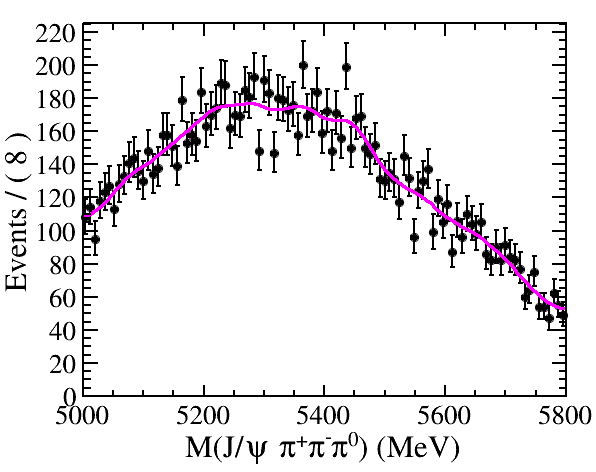

In [115]:
c = ROOT.TCanvas(f"Bd2omegaJpsi_0trueg", "", 600, 500)
frame = plot_fit(mass, ds_bd0g, wsBd['kdBz0g'])   
frame.Draw()
c.Draw()
c.SaveAs("../output/plots/Bd2omegaJpsi_0trueg.png")

In [116]:
c = ROOT.TCanvas(f"Bd2omegaJpsi_1trueg", "", 600, 500)
frame = plot_fit(mass, ds_bd1g, wsBd['kdBz1g'])   
frame.Draw()
c.SaveAs("../output/plots/Bd2omegaJpsi_1trueg.png")

Info in <TCanvas::Print>: png file ../output/plots/Bd2omegaJpsi_1trueg.png has been created


In [117]:
pdfBd = wsBd["sigmod"]
rBd = pdfBd.fitTo(ds_bd2g, Save=True, PrintLevel=-1)
rBd.Print("v")

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb1,cb2)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: deactivating const optimization

  RooFitResult: minimized FCN value: 415400, estimated distance to minimum: 9.942e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value     
  --------------------  ------------
                    n1    5.0000e+00
                    n2    5.0000e+00

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                    a1   -5.0000e+00   -8.9630e-01 +/-  1.24e-02  <none>
                    a2    5.0000e+00    1.0857e+00 +/-  2.26e-02  <none>
                    f1    5.0000e-01    6.6949e-01

In [118]:
c = ROOT.TCanvas(f"Bd2omegaJpsi_2trueg", "", 600, 500)
frame = plot_fit(mass, ds_bd2g, wsBd["sigmod"], params=True)   
frame.Draw()
c.SaveAs("../output/plots/Bd2omegaJpsi_2trueg.png")

Info in <TCanvas::Print>: png file ../output/plots/Bd2omegaJpsi_2trueg.png has been created


In [122]:
wsBd['a1'].setConstant(False)
wsBd['a2'].setConstant(False)
wsBd['f1'].setConstant(False)
wsBd['sigma'].setConstant(False)
wsBd['mean'].setConstant(False)
modelBd = wsBd["peakmod"]
rrBd = modelBd.fitTo(ds_bd, Save=True, PrintLevel=-1)
rrBd.Print("v")

[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Minimization --  The following expressions have been identified as constant and will be precalculated and cached: (kdBz0g,kdBz1g)
[#1] INFO:Minimization --  The following expressions will be evaluated in cache-and-track mode: (cb1,cb2)
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.06247
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.06247
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.06247
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.06247
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(peakmod WARNING: sum of PDF coefficients not in range [0-1], value=1.06247
[#0] WARNING:Eval -- RooAddPdf::updateCoefCac

In [123]:
c = ROOT.TCanvas(f"Bd2omegaJpsi_rdmgamma", "", 600, 500)
components = [("sigmod", "b", "--"), ("kdBz1g", "c", "-."), ("kdBz0g", "g", "-.")]
frame = plot_fit(mass, ds_bd, modelBd, components=components, params=True)   
frame.Draw()
c.SaveAs("../output/plots/Bd2omegaJpsi_rdmgamma.png")

[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (sigmod)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: (cb1,cb2)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (kdBz1g)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) directly selected PDF components: (kdBz0g)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(peakmod) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file ../output/plots/Bd2omegaJpsi_rdmgamma.png has been created


In [124]:
wsBd.writeToFile("../output/rootfiles/Bd2omegaJpsi_mc_fit.root")

False

In [138]:
#ws.SetName("wsBs")
ws.writeToFile("../output/rootfiles/Bs2etaJpsi_mc_fit.root")

False

#### STOP HERE

In [ ]:
def cand_truth(cand, trueid, mother=[], op='&&'):
    cut = f'abs({cand}_TRUEID)=={trueid}'
    lab = 'MC'
    for m in mother:
        cut = f'{cut} && abs({cand}_{lab}_MOTHER_ID)=={m}'
        lab = '_'.join([lab, 'GD'])
    return cut

In [ ]:
print(cand_truth('muplus', 13, [443, 511]))
print(cand_truth('gamma', 22, [11, 223, 511]))

In [ ]:
def extend_mctruth(df):
    mup = cand_truth('muplus', 13, [443, 511])
    mum = cand_truth('muminus', 13, [443, 511])
    pip = cand_truth('piplus', 211, [223, 511])
    pim = cand_truth('piminus', 211, [223, 511])
    g1 = cand_truth('gamma1', 22, [111, 223, 511])
    g2 = cand_truth('gamma2', 22, [111, 223, 511])
    
    jpsi = '&&'.join([mup, mum, 'muplus_MC_MOTHER_KEY==muminus_MC_MOTHER_KEY'])
    pip = '&&'.join([pip, 'piplus_MC_GD_MOTHER_KEY==muplus_MC_GD_MOTHER_KEY'])
    pim = '&&'.join([pim, 'piminus_MC_GD_MOTHER_KEY==muminus_MC_GD_MOTHER_KEY'])
    pi0 = '&&'.join([g1, g2, 'gamma1_MC_MOTHER_KEY==gamma2_MC_MOTHER_KEY'])
    
    b_2trueg = f"{jpsi} && {pip} && {pim} && {pi0}"
    b_1trueg = f"{jpsi} && {pip} && {pim} && (({g1} && !({g2})) || (!({g1}) && {g2}))"
    b_0trueg = f"{jpsi} && {pip} && {pim} && !({g1}) && !({g2})"

    df = df.Define('mctruth_pip', pip)\
           .Define('mctruth_pim', pim)\
           .Define('mctruth_g1', g1)\
           .Define('mctruth_g2', g2)\
           .Define('mctruth_pi0', pi0)\
           .Define('mctruth_jpsi', jpsi)\
           .Define('mctruth_b_2trueg', b_2trueg)\
           .Define('mctruth_b_1trueg', b_1trueg)\
           .Define('mctruth_b_0trueg', b_0trueg)
    return df

In [ ]:
def arr_from_friends(main, friend, tree='DecayTree', colpattern=None, alt=False):
    f = ROOT.TFile.Open(main)
    ff = ROOT.TFile.Open(friend)
    t = f.Get(tree)
    tf = ff.Get(tree)
    t.ResetBit(ROOT.TTree.EStatusBits.kEntriesReshuffled)
    tf.ResetBit(ROOT.TTree.EStatusBits.kEntriesReshuffled)
    t.AddFriend(tf)

    df = ROOT.RDataFrame(t)

    df = filter(df)
    df = extend_dtf(df)
    if alt:
        df = extend_mctruth_alt(df)
    else:
        df = extend_mctruth(df)

    report = df.Report()

    cols = df.GetColumnNames()
    cols = [str(c) for c in cols]

    if colpattern:
        pattern = re.compile(colpattern)
        cols = [c for c in cols if pattern.match(c)]

    arr = ak.from_rdataframe(df, cols)
    
    report.Print()

    return arr

In [ ]:
pattern = r'^(B_(?!(JpsiConsDTF|Hlt|pi0ConsDTF))|Jpsi_(?!Hlt)|omega_|pi0_|mctruth)'

In [ ]:
arrs = []
for main, friend in zip(files, pidcorr_files):
    arrs.append(arr_from_friends(main, friend, colpattern=pattern))

In [ ]:
arrs = ak.concatenate(arrs)

In [ ]:
import mplhep

In [ ]:
h_B_DTF_M = Hist.new.Regular(100, 5000, 6000, name=r"$M(J/\psi\;K^+\;\pi^0)$ $(MeV)$").Double();
h_B_DTF_M.fill(arrs[arrs.mctruth_b_2trueg].B_JpsiDTF_M);

In [ ]:
h_B1g_DTF_M = Hist.new.Regular(100, 5000, 6000, name=r"$M(J/\psi\;K^+\gamma\gamma)$ $(MeV)$").Double();
h_B1g_DTF_M.fill(arrs[arrs.mctruth_b_1trueg].B_JpsiDTF_M);

In [ ]:
h_B0g_DTF_M = Hist.new.Regular(100, 5000, 6000, name=r"$M(J/\psi\;K^+\gamma\gamma)$ $(MeV)$").Double();
h_B0g_DTF_M.fill(arrs[arrs.mctruth_b_0trueg].B_JpsiDTF_M);

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
mplhep.histplot(h_B_DTF_M, yerr=True, histtype='errorbar', ax=ax[0]);
mplhep.histplot(h_B_DTF_M, yerr=True, histtype='errorbar', ax=ax[1]);
mplhep.histplot(h_B1g_DTF_M, yerr=True, histtype='errorbar', ax=ax[1]);
mplhep.histplot(h_B0g_DTF_M, yerr=True, histtype='errorbar', ax=ax[2]);